## TP3: Introducción al aprendizaje automático

In [1]:
import pandas as pd

In [2]:
Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2020_Mentoria_LluviasExtremas/master/dataset/datos_diarios_cordoba.csv", parse_dates = True, index_col="fecha")
id_Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2020_Mentoria_LluviasExtremas/master/dataset/metadatos_estaciones.csv")

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.

In [3]:
full_dataset = pd.read_csv('./datasetTP2/datos_diarios_cordoba_terra_chirps.csv')

In [4]:
dataset = full_dataset[(full_dataset['nombre'] == 'La Florida') | (full_dataset['nombre'] == 'Marcos Juarez INTA')]
dataset.loc[:, 'fecha'] = pd.to_datetime(dataset['fecha'])
dataset.reset_index(inplace=True)
dataset = dataset.drop(['Unnamed: 0'], axis=1)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [6]:
def get_hydro_year(date_, start_month=7):
    year = date_.strftime('%Y')
    month = date_.strftime('%m')
    offset = 1 if int(month) >= start_month - 1 else 0
    hydro_year = int(year) + offset - 1
    return hydro_year

def add_hydro_year(dataset):
    dataset = dataset.copy()
    dataset.reset_index(inplace=True)
    dataset['hydro_year'] = dataset['fecha'].apply(get_hydro_year)
    return dataset

def remove_cols(dataset, cols=['level_0', 'ano', 'mes', 'caudal', 'tmed', 'vmax_d', 'vmax_f']):
    return dataset.drop(cols, axis=1)

def get_grouped_dataset(dataset, group=['omm_id', 'hydro_year']):
    return dataset.groupby(group)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature].iloc[i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements
    
def number_days_over_threshold(dataset, threshold = 10):
    rainfall_data = dataset.copy()
    rainfall_data = rainfall_data[['omm_id', 'hydro_year', 'prcp']]
    rainfall_data['day_beyond_threshold'] = rainfall_data.prcp > threshold
    rainfall_data = rainfall_data.groupby(['omm_id', 'hydro_year'], as_index=False).day_beyond_threshold.sum()
    return(rainfall_data)

def rainy_days_over_percentile(dataset, threshold = 0.9):
    rainfall_data = dataset.copy()
    rainfall_data = rainfall_data[['omm_id', 'hydro_year', 'prcp']]
    rainfall_data = rainfall_data[rainfall_data.prcp > 0.1]
    reference_quantiles = rainfall_data.groupby(['omm_id'], as_index=False).prcp.quantile(threshold)
    reference_quantiles.rename(columns={'prcp': 'prcp_threshold'}, inplace=True) 
    rainfall_data = pd.merge(rainfall_data, reference_quantiles, on = 'omm_id')
    rainfall_data['day_beyond_threshold'] = rainfall_data.prcp > rainfall_data.prcp_threshold    
    rainfall_data = rainfall_data.groupby(['omm_id', 'hydro_year'], as_index=False).day_beyond_threshold.sum()
    return(rainfall_data)

def add_days_over_threshold(dataset_yearly, dataset, threshold):
    dataset_ = number_days_over_threshold(dataset, threshold)
    dataset_ = dataset_.rename(columns = {'day_beyond_threshold': f'day_{threshold}'})
    return pd.merge(dataset_yearly, dataset_, on = ['hydro_year', 'omm_id'])


def add_days_over_percentile(dataset_yearly, dataset, threshold):
    dataset_ = rainy_days_over_percentile(dataset, threshold)
    dataset_ = dataset_.rename(columns = {'day_beyond_threshold': f'day_{int(100 * threshold)}'})
    return pd.merge(dataset_yearly, dataset_, on = ['hydro_year', 'omm_id'])

def add_lagged_features(dataset_, columns, N):
    dataset = dataset_.copy()
    for feature in columns:
        if feature != 'PMDA':
            for n in range(1, N):
                derive_nth_day_feature(dataset, feature, n)
    return dataset

In [7]:
dataset = add_hydro_year(dataset)

In [8]:
dataset.head()

,level_0,index,fecha,ano,mes,omm_id,nombre,prcp,tmax,tmin,tmed,vmax_d,vmax_f,vmed,caudal,ETreal_mm,HumedadSuelo_mm,RadSolar_Wpm2,PresionVapor_hPa,IndicePalmer_porc,hydro_year
0,0,43473,1967-10-01,1967,10,87466,Marcos Juarez INTA,0.0,25.8,11.7,NaN,NaN,NaN,3.333333,NaN,NaN,NaN,NaN,NaN,NaN,1967
1,1,43474,1967-10-02,1967,10,87466,Marcos Juarez INTA,7.5,25.0,14.4,NaN,NaN,NaN,4.444444,NaN,NaN,NaN,NaN,NaN,NaN,1967
2,2,43475,1967-10-03,1967,10,87466,Marcos Juarez INTA,21.0,23.4,13.2,NaN,NaN,NaN,6.666667,NaN,NaN,NaN,NaN,NaN,NaN,1967
3,3,43476,1967-10-04,1967,10,87466,Marcos Juarez INTA,0.0,21.2,14.0,NaN,NaN,NaN,1.944444,NaN,NaN,NaN,NaN,NaN,NaN,1967
4,4,43477,1967-10-05,1967,10,87466,Marcos Juarez INTA,0.0,22.5,11.0,NaN,NaN,NaN,5.833333,NaN,NaN,NaN,NaN,NaN,NaN,1967


In [9]:
dataset = dataset[dataset.hydro_year >= 1961]
dataset_yearly = dataset.groupby(['hydro_year', 'omm_id', 'nombre']).agg({'prcp':'sum', 
                                                                          'tmax':'mean', 
                                                                          'tmin':'mean',
                                                                          'ETreal_mm':'sum', 
                                                                          'HumedadSuelo_mm':'mean', 
                                                                          'RadSolar_Wpm2':'mean', 
                                                                          'PresionVapor_hPa':'mean', 
                                                                          'IndicePalmer_porc':'mean'})
dataset_yearly = dataset_yearly.rename(columns = {'prcp':'PMDA'})
dataset_yearly.head()


,,,PMDA,tmax,tmin,ETreal_mm,HumedadSuelo_mm,RadSolar_Wpm2,PresionVapor_hPa,IndicePalmer_porc
hydro_year,omm_id,nombre,,,,,,,,
1961,1,La Florida,808.8,20.622466,6.174247,19589.3,84.493151,195.900822,9.490192,1.642795
1962,1,La Florida,516.5,20.723288,6.183014,18655.3,62.339726,198.981644,9.338630,-0.506466
1963,1,La Florida,409.4,19.883060,6.631694,20268.9,30.008197,193.853279,8.933005,-0.278579
1964,1,La Florida,884.2,20.331233,5.275342,18521.8,23.090411,200.170137,8.996822,-0.188795
1965,1,La Florida,1081.9,20.694795,6.491781,19048.7,21.098630,200.598356,9.244000,-1.731479


In [10]:
# Calcular la cantidad de días con precipitacion por encima de un determinado umbral
# y gregar al dataset por año hidrologico
dataset_yearly = add_days_over_threshold(dataset_yearly, dataset, 10)
dataset_yearly = add_days_over_threshold(dataset_yearly, dataset, 20)
dataset_yearly = add_days_over_threshold(dataset_yearly, dataset, 50)

In [11]:
# Calcular la cantidad de días con precipitacion por encima de un determinado percentil
# y agregar al dataset por año hidrologico
dataset_yearly = add_days_over_percentile(dataset_yearly, dataset, .9)
dataset_yearly = add_days_over_percentile(dataset_yearly, dataset, .95)
dataset_yearly = add_days_over_percentile(dataset_yearly, dataset, .99)

In [12]:
dataset_yearly.head()

,hydro_year,omm_id,PMDA,tmax,tmin,ETreal_mm,HumedadSuelo_mm,RadSolar_Wpm2,PresionVapor_hPa,IndicePalmer_porc,day_10,day_20,day_50,day_90,day_95,day_99
0,1961,1,808.8,20.622466,6.174247,19589.3,84.493151,195.900822,9.490192,1.642795,23.0,17.0,4.0,6.0,4.0,2.0
1,1962,1,516.5,20.723288,6.183014,18655.3,62.339726,198.981644,9.338630,-0.506466,17.0,10.0,1.0,6.0,3.0,0.0
2,1963,1,409.4,19.883060,6.631694,20268.9,30.008197,193.853279,8.933005,-0.278579,14.0,8.0,1.0,2.0,1.0,0.0
3,1964,1,884.2,20.331233,5.275342,18521.8,23.090411,200.170137,8.996822,-0.188795,32.0,17.0,1.0,5.0,1.0,0.0
4,1965,1,1081.9,20.694795,6.491781,19048.7,21.098630,200.598356,9.244000,-1.731479,30.0,23.0,3.0,9.0,4.0,1.0


In [13]:
# Desde acá separamos por estación y empezamos a 
# trabajar los datasets por separado
dataset_florida = dataset_yearly[dataset_yearly['omm_id'] == 1]
dataset_marcos = dataset_yearly[dataset_yearly['omm_id'] == 87466]

dataset_florida.head()

,hydro_year,omm_id,PMDA,tmax,tmin,ETreal_mm,HumedadSuelo_mm,RadSolar_Wpm2,PresionVapor_hPa,IndicePalmer_porc,day_10,day_20,day_50,day_90,day_95,day_99
0,1961,1,808.8,20.622466,6.174247,19589.3,84.493151,195.900822,9.490192,1.642795,23.0,17.0,4.0,6.0,4.0,2.0
1,1962,1,516.5,20.723288,6.183014,18655.3,62.339726,198.981644,9.338630,-0.506466,17.0,10.0,1.0,6.0,3.0,0.0
2,1963,1,409.4,19.883060,6.631694,20268.9,30.008197,193.853279,8.933005,-0.278579,14.0,8.0,1.0,2.0,1.0,0.0
3,1964,1,884.2,20.331233,5.275342,18521.8,23.090411,200.170137,8.996822,-0.188795,32.0,17.0,1.0,5.0,1.0,0.0
4,1965,1,1081.9,20.694795,6.491781,19048.7,21.098630,200.598356,9.244000,-1.731479,30.0,23.0,3.0,9.0,4.0,1.0


In [14]:
dataset_yearly.columns

Index(['hydro_year', 'omm_id', 'PMDA', 'tmax', 'tmin', 'ETreal_mm',
       'HumedadSuelo_mm', 'RadSolar_Wpm2', 'PresionVapor_hPa',
       'IndicePalmer_porc', 'day_10', 'day_20', 'day_50', 'day_90', 'day_95',
       'day_99'],
      dtype='object')

In [15]:
lagged_features_columns = ['tmax', 'tmin', 
       'ETreal_mm', 'HumedadSuelo_mm', 'RadSolar_Wpm2', 'PresionVapor_hPa',
       'IndicePalmer_porc', 'day_10', 'day_20', 'day_50', 'day_90', 'day_95', 'day_99']
target = ['PMDA']

In [16]:
dataset_florida = add_lagged_features(dataset_florida, lagged_features_columns, 4)
dataset_marcos = add_lagged_features(dataset_marcos, lagged_features_columns, 4)

In [17]:
print(dataset_florida.isnull().values.any(), dataset_marcos.isnull().values.any())

True True


In [18]:
dataset_marcos = dataset_marcos.dropna()
dataset_florida = dataset_florida.dropna()

In [19]:
not_features_cols = ['index', 'fecha', 'nombre', 'PMDA', 'omm_id'] # Agregue el omm_id, cualquier cosa lo sacamos...
features_columns = [col for col in dataset_florida.columns if col not in not_features_cols]

In [20]:
features_columns

['hydro_year',
 'tmax',
 'tmin',
 'ETreal_mm',
 'HumedadSuelo_mm',
 'RadSolar_Wpm2',
 'PresionVapor_hPa',
 'IndicePalmer_porc',
 'day_10',
 'day_20',
 'day_50',
 'day_90',
 'day_95',
 'day_99',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'ETreal_mm_1',
 'ETreal_mm_2',
 'ETreal_mm_3',
 'HumedadSuelo_mm_1',
 'HumedadSuelo_mm_2',
 'HumedadSuelo_mm_3',
 'RadSolar_Wpm2_1',
 'RadSolar_Wpm2_2',
 'RadSolar_Wpm2_3',
 'PresionVapor_hPa_1',
 'PresionVapor_hPa_2',
 'PresionVapor_hPa_3',
 'IndicePalmer_porc_1',
 'IndicePalmer_porc_2',
 'IndicePalmer_porc_3',
 'day_10_1',
 'day_10_2',
 'day_10_3',
 'day_20_1',
 'day_20_2',
 'day_20_3',
 'day_50_1',
 'day_50_2',
 'day_50_3',
 'day_90_1',
 'day_90_2',
 'day_90_3',
 'day_95_1',
 'day_95_2',
 'day_95_3',
 'day_99_1',
 'day_99_2',
 'day_99_3']

In [21]:
features_dataset_florida = dataset_florida[features_columns]

target_df = dataset_florida[target]
features_dataset_florida.shape, target_df.shape

((55, 53), (55, 1))

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

In [23]:
X = features_dataset_florida.copy()
y = target_df.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((44, 53), (11, 53))

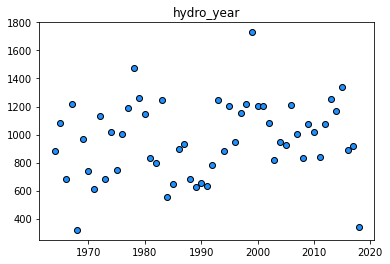

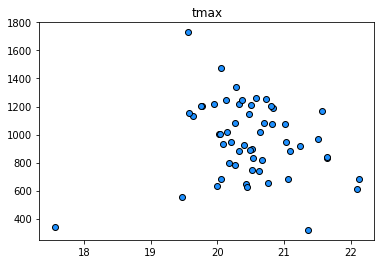

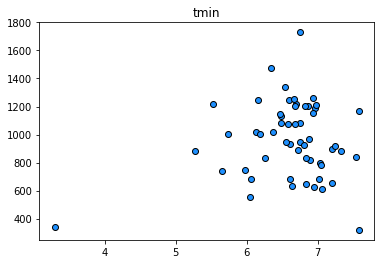

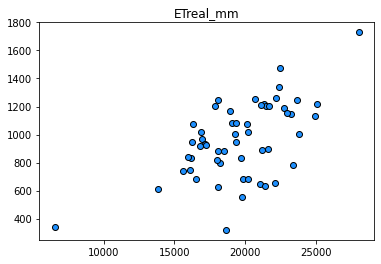

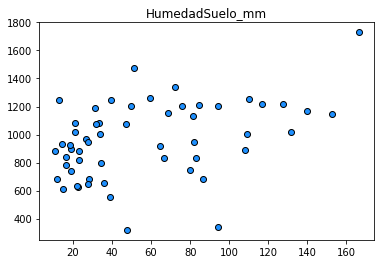

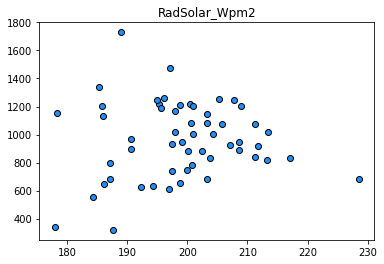

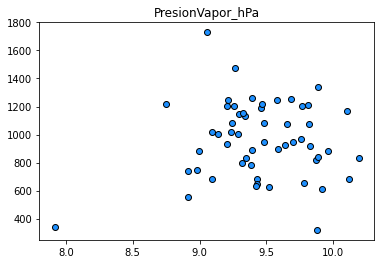

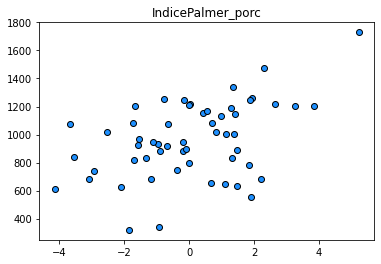

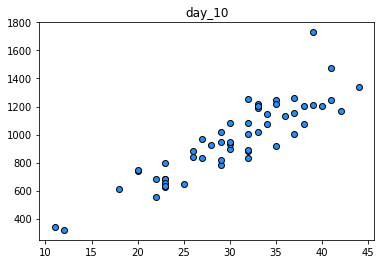

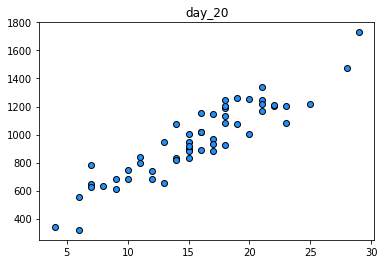

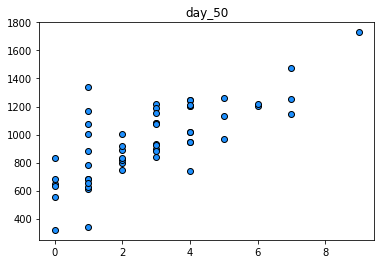

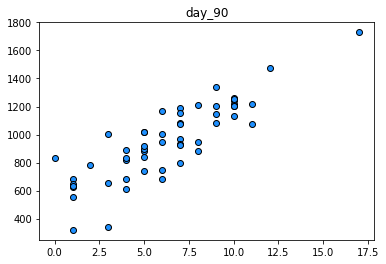

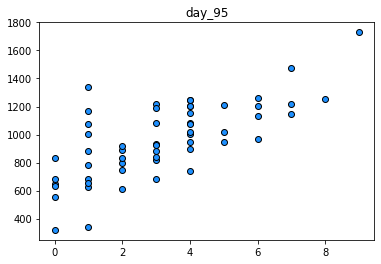

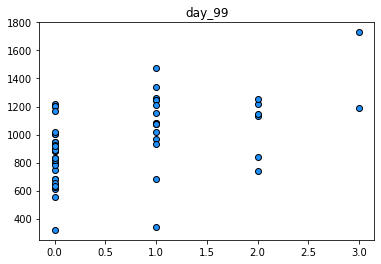

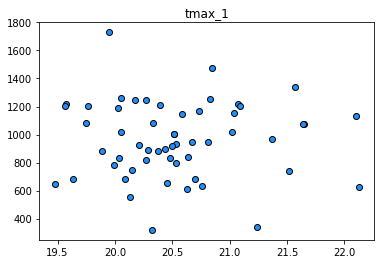

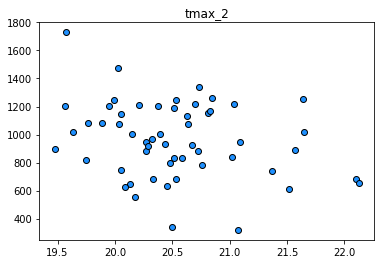

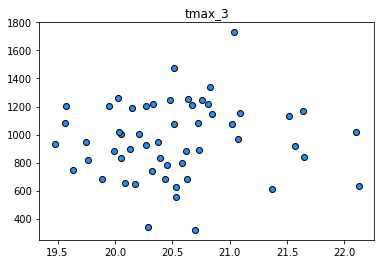

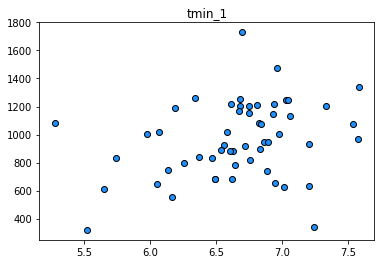

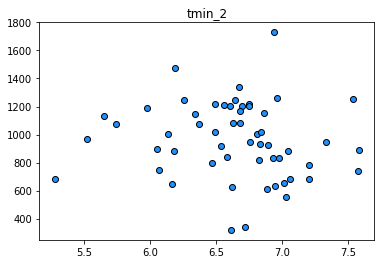

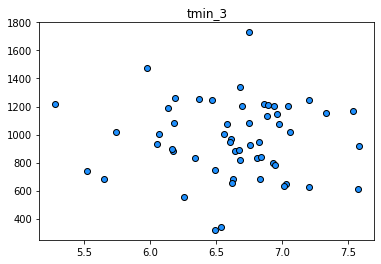

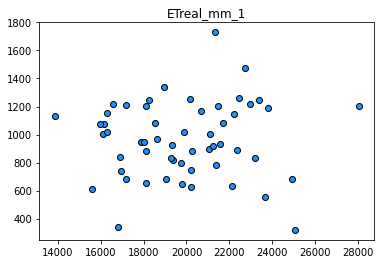

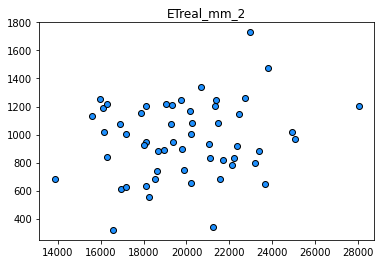

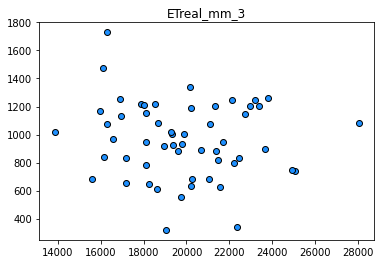

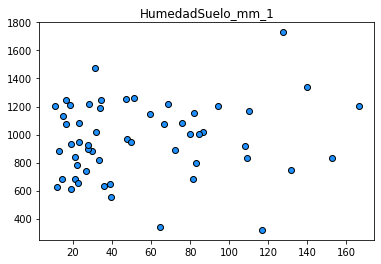

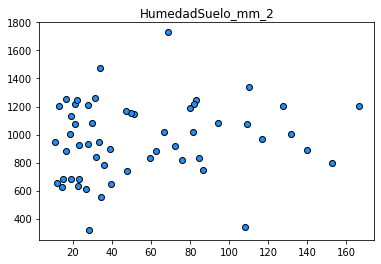

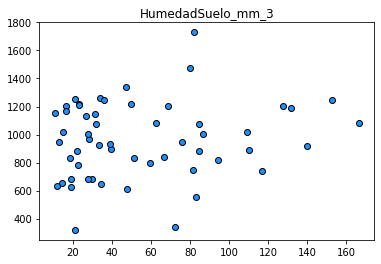

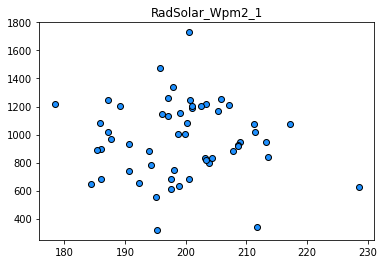

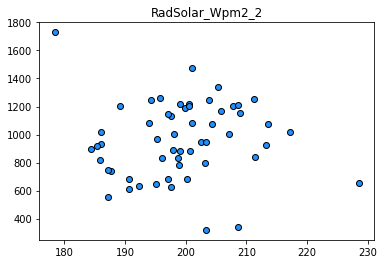

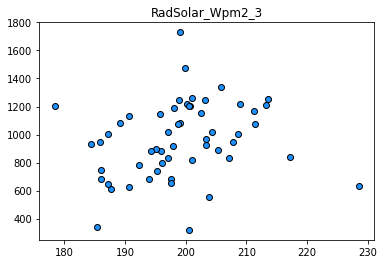

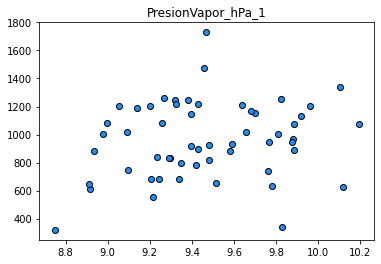

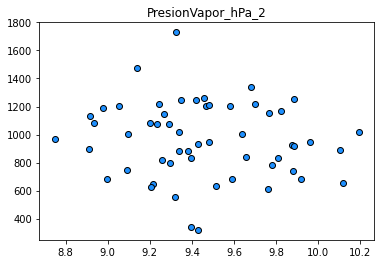

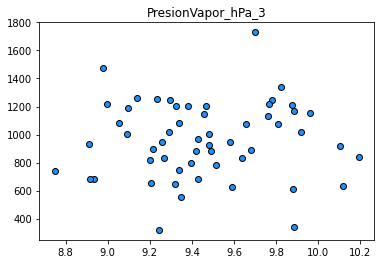

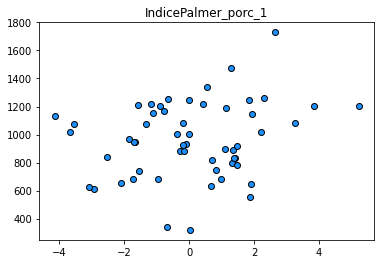

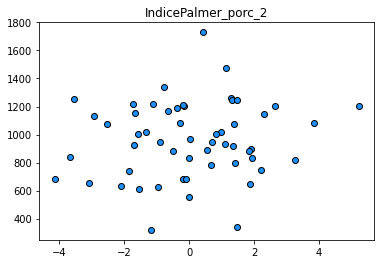

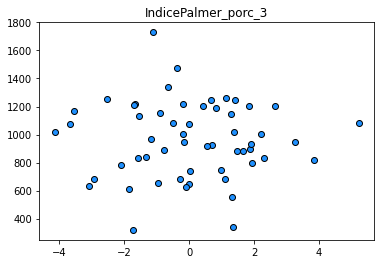

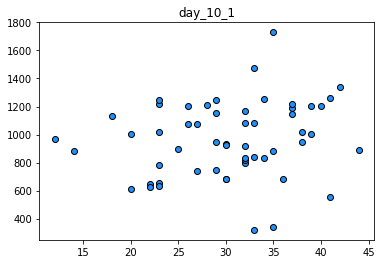

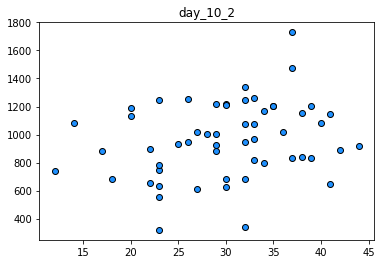

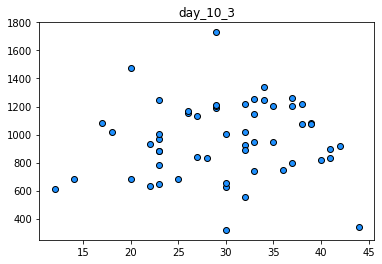

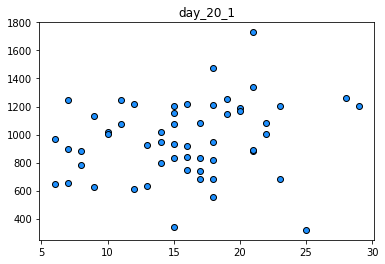

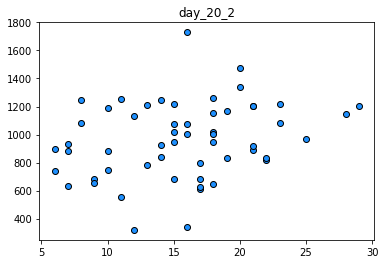

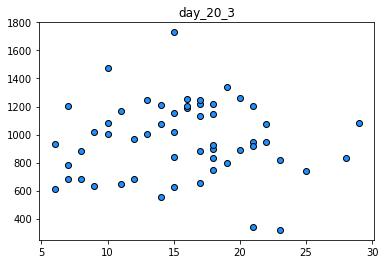

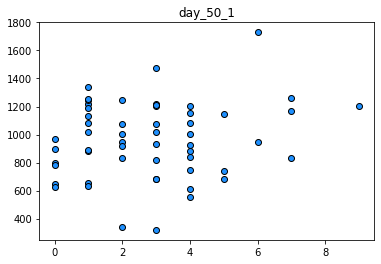

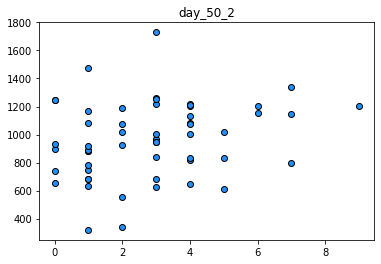

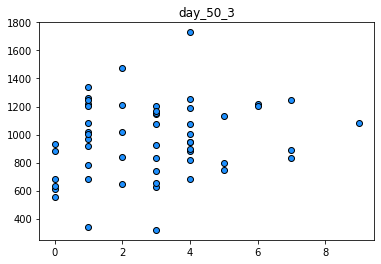

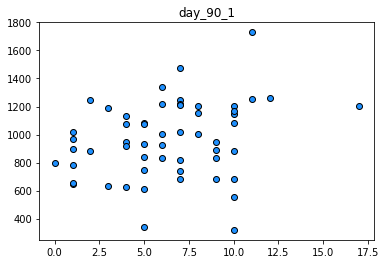

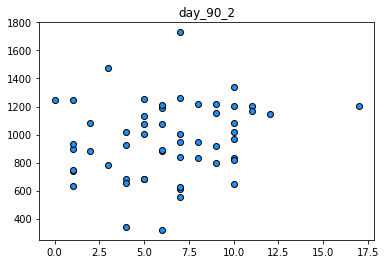

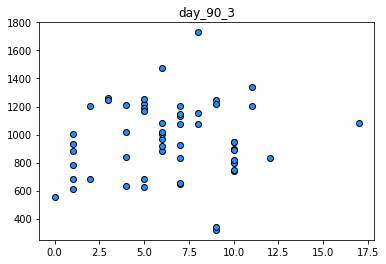

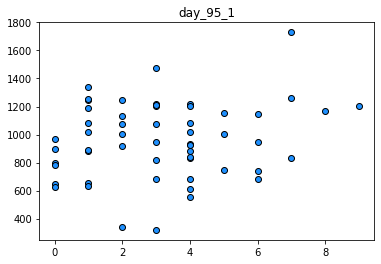

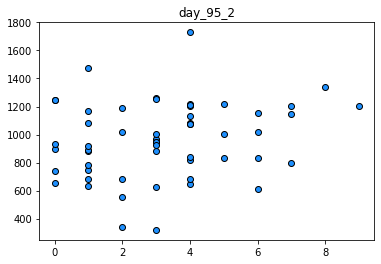

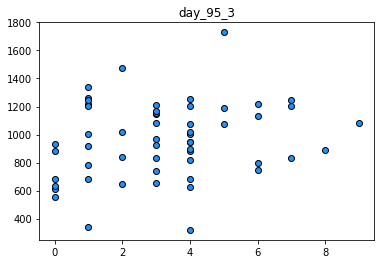

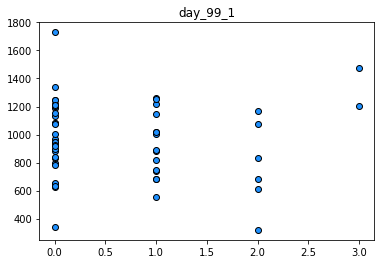

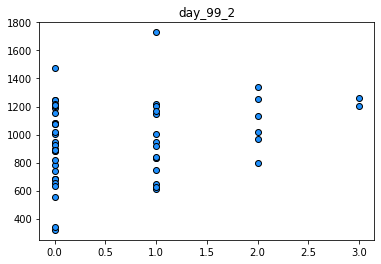

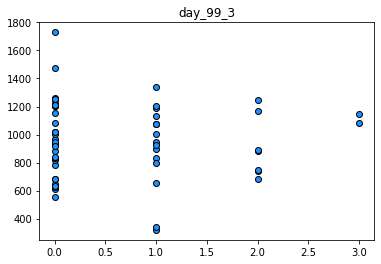

In [28]:
# Comente la parte de subplot porque no nos mostraba
# todos los gráficos

# fig = plt.figure(figsize=(30,20))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)
# i = 1
for feature in features_columns:
#      ax = fig.add_subplot(3, 5, i)
    plt.scatter(X.loc[:, feature], y, facecolor='dodgerblue', edgecolor='k', label='datos')
    plt.title(feature)
#     i += 1
    plt.show()

In [36]:
feature = ['day_10', 'tmin']
# X_train_f = X_train.loc[:, feature]
# X_test_f = X_test.loc[:, feature]
X_train_f = X_train
X_test_f = X_test
X_train_f.shape, X_test_f.shape

((44, 53), (11, 53))

In [37]:
model = LinearRegression()
model.fit(X_train_f, y_train)

LinearRegression()

In [38]:
# y_train_pred = model.predict(X_train_f)
# y_test_pred = model.predict(X_test_f)

# train_error = mean_squared_error(y_train, y_train_pred)
# test_error = mean_squared_error(y_test, y_test_pred)
# print(f'Train error: {train_error}')
# print(f'Test error: {test_error}')

In [39]:
# train:
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X_train_f, y_train)

# predict:
y_train_pred = model.predict(X_train_f)
y_test_pred = model.predict(X_test_f)

# evaluate:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

In [40]:
train_error, test_error

(3.1737581369411907e-21, 56459.99410443881)